<a href="https://colab.research.google.com/github/Yogeeth/neuromorphic-lif-rtl/blob/main/SNNExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
# Load CSV
df = pd.read_csv("data.csv")

print("Loaded data shape:", df.shape)
print("Columns:", df.columns.tolist())
# Extract neuron parameters
params_df = df["threshold"]

print("\nNeuron parameters:")
print(params_df.head())
# Extract synaptic weights
weight_cols = [c for c in df.columns if c.startswith("w_in_")]
weights = df[weight_cols].to_numpy()

print("\nWeights shape:", weights.shape)

# Quantize weights (float -> int8)
SCALE = 128.0

weights_q = np.clip(
    np.round(weights * SCALE),
    -128,
    127
).astype(np.int8)

print("\nQuantized weights (int8):")
print(weights_q[:2])

# Save outputs
# Parameters (float)
params_df.to_csv("neuron_params.csv", index=False)

# Quantized weights (int8)
np.savetxt(
    "weights_int8.csv",
    weights_q,
    fmt="%d",
    delimiter=","
)

print("\nFiles generated:")
print(" - neuron_params.csv")
print(" - weights_int8.csv")


Loaded data shape: (10, 789)
Columns: ['neuron_index', 'threshold', 'reset_voltage', 'tau', 'beta_decay_factor', 'w_in_0', 'w_in_1', 'w_in_2', 'w_in_3', 'w_in_4', 'w_in_5', 'w_in_6', 'w_in_7', 'w_in_8', 'w_in_9', 'w_in_10', 'w_in_11', 'w_in_12', 'w_in_13', 'w_in_14', 'w_in_15', 'w_in_16', 'w_in_17', 'w_in_18', 'w_in_19', 'w_in_20', 'w_in_21', 'w_in_22', 'w_in_23', 'w_in_24', 'w_in_25', 'w_in_26', 'w_in_27', 'w_in_28', 'w_in_29', 'w_in_30', 'w_in_31', 'w_in_32', 'w_in_33', 'w_in_34', 'w_in_35', 'w_in_36', 'w_in_37', 'w_in_38', 'w_in_39', 'w_in_40', 'w_in_41', 'w_in_42', 'w_in_43', 'w_in_44', 'w_in_45', 'w_in_46', 'w_in_47', 'w_in_48', 'w_in_49', 'w_in_50', 'w_in_51', 'w_in_52', 'w_in_53', 'w_in_54', 'w_in_55', 'w_in_56', 'w_in_57', 'w_in_58', 'w_in_59', 'w_in_60', 'w_in_61', 'w_in_62', 'w_in_63', 'w_in_64', 'w_in_65', 'w_in_66', 'w_in_67', 'w_in_68', 'w_in_69', 'w_in_70', 'w_in_71', 'w_in_72', 'w_in_73', 'w_in_74', 'w_in_75', 'w_in_76', 'w_in_77', 'w_in_78', 'w_in_79', 'w_in_80', 'w_in_

Running simulation on 100 images...
Processed 10/100 images
Processed 20/100 images
Processed 30/100 images
Processed 40/100 images
Processed 50/100 images
Processed 60/100 images
Processed 70/100 images
Processed 80/100 images
Processed 90/100 images
Processed 100/100 images

Final Accuracy at Step 20: 95.0%


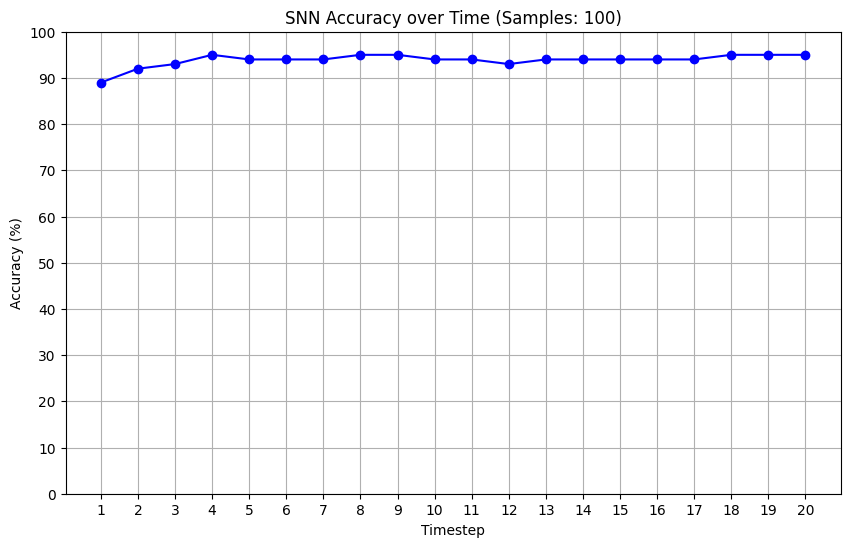

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Parameters
NUM_SAMPLES = 100             # Number of images to test
TIME_STEPS = 20
TAU_SHIFT = 8
THRESHOLD_INT = 128
SEED = 2463534242

# Setup
def xorshift32(state):
    state ^= (state << 13) & 0xFFFFFFFF
    state ^= (state >> 17)
    state ^= (state << 5) & 0xFFFFFFFF
    return state & 0xFFFFFFFF

# Load Weights
W = torch.tensor(
    np.loadtxt("weights_int8.csv", delimiter=",", dtype=np.int8),
    dtype=torch.int32
)

# Load Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 255).byte().view(-1))
])
dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)


accuracy_history = np.zeros(TIME_STEPS) # Stores correct count per timestep

print(f"Running simulation on {NUM_SAMPLES} images...")

for img_idx in range(NUM_SAMPLES):
    image, label = dataset[img_idx]
    image = image.int()

    # Reset State per Image
    membrane = torch.zeros(10, dtype=torch.int32)
    spike_count = torch.zeros(10, dtype=torch.int32)
    rng_state = SEED # Reset RNG to ensure deterministic behavior per image

    for t in range(TIME_STEPS):
        # Generate Input Spikes (Bit-true loop)
        spikes_in = torch.zeros(784, dtype=torch.int32)
        for i in range(784):
            rng_state = xorshift32(rng_state)
            rand8 = rng_state & 0xFF
            if rand8 < image[i]:
                spikes_in[i] = 1

        # Neuron Update
        current = torch.matmul(W, spikes_in)
        membrane = (membrane - (membrane >> TAU_SHIFT)) + current

        spikes_out = (membrane >= THRESHOLD_INT).int()
        membrane = membrane * (1 - spikes_out) # Hard reset
        spike_count += spikes_out

        # Check Accuracy at this Timestep
        pred = spike_count.argmax().item()
        if pred == label:
            accuracy_history[t] += 1

    if (img_idx + 1) % 10 == 0:
        print(f"Processed {img_idx + 1}/{NUM_SAMPLES} images")

# Plotting
accuracy_percentage = (accuracy_history / NUM_SAMPLES) * 100

print(f"\nFinal Accuracy at Step {TIME_STEPS}: {accuracy_percentage[-1]}%")

plt.figure(figsize=(10, 6))
plt.plot(range(1, TIME_STEPS + 1), accuracy_percentage, marker='o', linestyle='-', color='b')
plt.title(f'SNN Accuracy over Time (Samples: {NUM_SAMPLES})')
plt.xlabel('Timestep')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.xticks(range(1, TIME_STEPS + 1))
plt.yticks(range(0, 101, 10))
plt.show()

In [ ]:
W.shape

torch.Size([10, 784])

In [ ]:
# Setup
SEED = 2463534242
SAMPLES_PER_CLASS = 200  # How many images to test per digit

print(f"--- Average Input Current (First Timestep, {SAMPLES_PER_CLASS} Samples) ---")
print(f"{'Digit':<6} | {'Avg Current':<12} | {'Min':<6} | {'Max':<6} | {'Status'}")
print("-" * 50)

# Test Loop
for target_digit in range(10):

    currents = []
    found_count = 0
    idx = 0

    # Loop until we find enough samples for this digit
    while found_count < SAMPLES_PER_CLASS:
        # Safety break if we run out of data
        if idx >= len(dataset):
            break

        image, label = dataset[idx]

        if label == target_digit:
            image = image.int()

            # Hardware Simulation for 1 Step
            rng_state = SEED # Reset seed for consistency across comparisons
            spikes_in = torch.zeros(784, dtype=torch.int32)

            for p in range(784):
                rng_state = xorshift32(rng_state)
                rand8 = rng_state & 0xFF
                if rand8 < image[p]:
                    spikes_in[p] = 1

            # Calculate current (Dot Product)
            curr = torch.matmul(W[target_digit], spikes_in).item()
            currents.append(curr)
            found_count += 1

        idx += 1


    # Stats & Report
    avg_curr = np.mean(currents)
    min_curr = np.min(currents)
    max_curr = np.max(currents)

    # Status Check:
    # If Avg is < 100, the neuron is very weak (might not spike).
    # If Avg is < 0, the neuron is broken (inhibits itself).
    if avg_curr < 0:
        status = "BROKEN"
    elif avg_curr < 100:
        status = "WEAK"
    else:
        status = "OK"

    print(f"{target_digit:<6} | {avg_curr:<12.1f} | {min_curr:<6} | {max_curr:<6} | {status}")

--- Average Input Current (First Timestep, 200 Samples) ---
Digit  | Avg Current  | Min    | Max    | Status
--------------------------------------------------
0      | 296.8        | -39    | 586    | OK
1      | 303.5        | -1     | 436    | OK
2      | 245.5        | -389   | 565    | OK
3      | 223.5        | -171   | 489    | OK
4      | 232.0        | -247   | 458    | OK
5      | 232.4        | -437   | 813    | OK
6      | 259.1        | -234   | 467    | OK
7      | 245.0        | -198   | 539    | OK
8      | 174.9        | -29    | 394    | OK
9      | 223.6        | -377   | 459    | OK
